## Accuracy Evaluation
---

In [1]:
import os
from constants import *

os.environ["PPLX_API_KEY"] = PPLX_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import asyncio
import json
import ast

In [3]:
example_df = pd.read_csv("climate.csv")

example_df["extraction"] = example_df["extraction"].apply(ast.literal_eval) # bodge to deal with csv storage
example_df["full_text"] = example_df['post_title'] + "\n\n" + example_df['self_text']

In [4]:
import re

def format_list(list):
    return "- " + "\n- ".join(list)

def extract_score(content):
    pattern = r"Score: \[(.*?)\]"
    match = re.search(pattern, content, re.DOTALL)
    
    if match:
        literal_list = match.group().replace("Score: ", "")
        return ast.literal_eval(literal_list)
    else: 
        raise Exception("List extraction failed!")

eval_system = """
You are a helpful assistant. Evaluate the summarized opinions and perspectives in the list compared the original text.  
After analysis, please provide a final accuracy in the form of a list. The score for each item should be "Correct", "Mostly Correct", "Partially Correct", or "Incorrect".

Output Format:
Brief Analysis: 
Score: ["Correct", "Incorrect", "Correct"]
"""
eval_template = "Original Text: \"{text}\" \n\n Summarized Opinions: \n {opinions}"

eval_prompt = ChatPromptTemplate.from_messages([("system", eval_system), ("human", eval_template)])

In [5]:
eval_llm = ChatOpenAI(temperature=0.2, model="gpt-4o")

eval_agent = eval_prompt | eval_llm

In [6]:
async def evaluate_by_row(series, eval_agent):
    t = series['full_text']
    o = format_list(series['extraction'])

    ana = eval_agent.invoke({'text': t, 'opinions': o}).content
    try:
        s = extract_score(ana)
        return ana, s
    except:
        print("Failed!")
        return(ana, [])

In [9]:
### RUN ONLY IF NECESSARY; The expensive, time consuming evaluation step.

num_samples = 100
eval_samples = example_df.sample(num_samples, random_state=42)

eval_results = await asyncio.gather(*[evaluate_by_row(row, eval_agent) for _,row in eval_samples.iterrows()])

eval_outputs, eval_scores = list(zip(*eval_results))
eval_ids = [i for i,_ in eval_samples.iterrows()]

List extraction failed!
Failed!


In [15]:
# Optional if you want to save
with open('evals.json', 'w') as f:
   json.dump({'outputs': eval_outputs, 'scores': eval_scores, 'ids': eval_ids}, f)

In [16]:
# Optional if you want to load
with open('evals.json', 'r') as f:
    data = json.load(f)
    eval_scores = data['scores']
    eval_outputs = data['outputs']
    eval_ids = data["ids"]

Absolute Counts [258, 17, 26, 16]
Percentages: [81.4, 5.4, 8.2, 5.0]
Are any unaccounted for? False


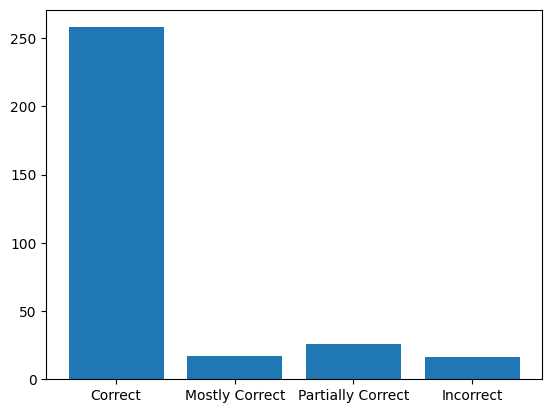

In [28]:
flat = [e for es in eval_scores for e in es]
labels = ["Correct", "Mostly Correct", "Partially Correct", "Incorrect"]

counts = [flat.count(l) for l in labels]

print("Absolute Counts", counts)
print("Percentages:", [round(c/len(flat)*100, 1) for c in counts])
print("Are any unaccounted for?", (not len(flat)-sum(counts)==0))

plt.bar(labels, counts, align='center')
plt.show()

### Analysis
---

In [29]:
loc = ["Incorrect" in l for l in eval_scores]

for exists, id, output in zip(loc, eval_ids, eval_outputs):
    if not exists:
        continue
    
    print("#"*20)
    print(example_df['full_text'][id])
    print("-"*20)
    print(format_list(example_df['extraction'][id]))
    print("-"*20)
    print(output)


####################
Democrats and Climate Activists Are on a Collision Course in 2024: In the run-up to a presidential election with dire climate implications, can activists afford to demonize Democrats? Can they afford not to?

Oh yes and Trump was running in 2016 to get tough on Saudi Arabia! And then he did that, it is not like Trump and Biden just kissed the feet of MBS like every other US president.

Again, I predict that if Biden loses oil drilling will increase at a similar rate than it did under Trump and Biden, but at a slower rate than under Obama.
--------------------
- Democrats and climate activists may be on a collision course in the 2024 presidential election.
- The author is skeptical about the effectiveness of demonizing Democrats for climate activists.
- The author predicts that oil drilling will increase under a Biden presidency, but at a slower rate than under Obama.
- The author criticizes Trump and Biden for their perceived lack of action against Saudi Arabia's i